In [1]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
 # Set path to CSV and read in CSV
csv_path = Path("DATA/ETH/ETH_DATA.csv")
eth_df=pd.read_csv(csv_path)

In [3]:
 # Set index as Date
eth_df = eth_df.set_index(pd.to_datetime(eth_df["Date"], infer_datetime_format=True))

# Display sample data
eth_df.head(10)

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,,
2015-08-09,ETH,2015-08-09,0.909046,1.749289,1.916540,0.794497
2015-08-10,ETH,2015-08-10,0.692321,0.909046,0.909046,0.692321
2015-08-11,ETH,2015-08-11,0.668067,0.692321,0.692321,0.654331
2015-08-12,ETH,2015-08-12,0.850151,0.668067,1.148621,0.668067
2015-08-13,ETH,2015-08-13,1.266023,0.850151,1.266023,0.850151
2015-08-14,ETH,2015-08-14,1.951460,1.266023,2.073329,1.149458
2015-08-15,ETH,2015-08-15,1.591219,1.951460,2.225695,1.591219
2015-08-16,ETH,2015-08-16,1.693707,1.591219,1.768860,1.591219
2015-08-17,ETH,2015-08-17,1.423244,1.693707,1.693707,1.099489


In [4]:
#check for na
eth_df.isnull().values.any()

False

In [5]:
#check main_df to see if everything is correct 
eth_df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,,
2015-08-09,ETH,2015-08-09,0.909046,1.749289,1.916540,0.794497
2015-08-10,ETH,2015-08-10,0.692321,0.909046,0.909046,0.692321
2015-08-11,ETH,2015-08-11,0.668067,0.692321,0.692321,0.654331
2015-08-12,ETH,2015-08-12,0.850151,0.668067,1.148621,0.668067
2015-08-13,ETH,2015-08-13,1.266023,0.850151,1.266023,0.850151


In [6]:
 # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
#assign atributes to names
#future period desides how many days ahead data will be 
FUTURE_PERIOD_PREDICT = 3

In [8]:
#set data 3 days back to compensate for lag
def add_future_column(eth_df):
    main_df= eth_df.copy()
    main_df['future'] = eth_df["Closing Price (USD)"].shift(-FUTURE_PERIOD_PREDICT)
    
    main_df.dropna(inplace=True)

    main_df.head()
    
    return main_df

In [9]:
#run df thorugh the function to add future coulumn to eth_eval
main_df = add_future_column(eth_df)
main_df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),future
Date,,,,,,,
2015-08-09,ETH,2015-08-09,0.909046,1.749289,1.916540,0.794497,0.850151
2015-08-10,ETH,2015-08-10,0.692321,0.909046,0.909046,0.692321,1.266023
2015-08-11,ETH,2015-08-11,0.668067,0.692321,0.692321,0.654331,1.951460
2015-08-12,ETH,2015-08-12,0.850151,0.668067,1.148621,0.668067,1.591219
2015-08-13,ETH,2015-08-13,1.266023,0.850151,1.266023,0.850151,1.693707


In [10]:
def get_data():
    
     # Set path to CSV and read in CSV
    csv_path = Path("DATA/ETH/ETH_DATA.csv")
    eth_df=pd.read_csv(csv_path)
    
     # Set index as Date
    eth_df = eth_df.set_index(pd.to_datetime(eth_df["Date"], infer_datetime_format=True))
    
    #run df thorugh the function to add future coulumn to eth_eval
    main_df = add_future_column(eth_df)
    # save data coulmnn 
    date = main_df.Date
    
    
    #remove eth column 
    main_df = main_df.drop(columns = ['Currency'])
    main_df = main_df.drop(columns= ['Date'])

    columns = main_df.columns
    
    
    # Importing the MinMaxScaler from sklearn
    from sklearn.preprocessing import MinMaxScaler

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    scaler.fit(main_df)
    
    main_array = scaler.transform(main_df)
    
    RES = pd.DataFrame(data=main_array, columns = columns)
    
    RES = RES.set_index(date)
    
    
    
    return RES,scaler

In [11]:
#reshape
def expand_windowed_data(X1,length_of_sample):
    """LSTM is expecting a 3-D data structure with (batch number, time steps, features)"""
    X2 = create_rolling_windows(X1, length_of_sample)
    X3 = X2.reshape(-1, length_of_sample, X1.shape[1])
    return X3 

In [12]:
def create_rolling_windows(values, count):
    """create a set of records that have the first count rows, then the same number of rows offset by one etc.
    example=abcdefghijklmn
    create_rolling_window(example, 3)
    would return abcbcdcdedefefgfghghihijijkjklklmlmn"""
    firstitem = values[:count]
    items = [values[window_start:window_start + count] for window_start in range(1, 1 + len(values) - count)]
    total = np.append(firstitem, items)
    return total

In [13]:
main_df, scaler = get_data()

In [14]:
main_df

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),future
Date,,,,,
2015-08-09,0.000116,0.000316,0.000325,0.000096,0.000102
2015-08-10,0.000064,0.000115,0.000096,0.000070,0.000203
2015-08-11,0.000058,0.000063,0.000046,0.000060,0.000369
2015-08-12,0.000102,0.000057,0.000150,0.000064,0.000281
2015-08-13,0.000203,0.000101,0.000177,0.000110,0.000306
...,...,...,...,...,...
2021-07-19,0.442534,0.452552,0.437966,0.458085,0.485271
2021-07-20,0.429891,0.435115,0.420265,0.436956,0.503232
2021-07-21,0.476256,0.427497,0.463770,0.445578,0.524497


In [15]:
X1= main_df[["Closing Price (USD)"]].to_numpy()
y1 = main_df[["future"]].to_numpy()

In [16]:
#split data
split = int(0.7 * len(X1))
X_train = X1[: split]
X_test = X1[split:]

y_train = y1[: split]
y_test = y1[split:]

In [17]:
X_train = expand_windowed_data(X1,9)
y_train = expand_windowed_data(y1,9)

X_test = expand_windowed_data(X1,9)
y_test = expand_windowed_data(y1,9)

In [18]:
print(X1.shape,y1.shape)
print(X_train.shape,y_train.shape)

(2176, 1) (2176, 1)
(2168, 9, 1) (2168, 9, 1)


In [19]:
def create_model(shape):
    model = Sequential()
    model.add(LSTM(16, input_shape=shape, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(Dense(2))
    return model  

In [31]:

model = create_model(X_train.shape[1:3]) #The last two entries in the shape, data has shape (batches, timesteps, features)
model.compile(optimizer = "adam", loss="mse")
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
68/68 [==============================] - 3s 5ms/step - loss: 0.0166
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 3/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 5/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 6/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 7/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 8/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/100
68/68 [==============================] - 0s 5ms/step - loss: 8.1759e-04A: 0s - loss: 9.139
Epoch 11/100
68/68 [==============================] - 0s 5ms/step - loss: 6.5958e-04
Epoch 12/100
68/68 [==============================] - 0s 5ms/step - loss: 5.4530e-04
Epoch 

In [32]:
predictions = model.predict(X_test.reshape((-1,9,1)))


In [33]:
predictions.shape

(2168, 9, 2)

In [34]:
len(predictions)

2168

In [35]:
  
result= [i[8]for i in predictions]

result_2 = np.array(result)
print(result_2.shape)

(2168, 2)


In [36]:
result_2

array([[0.00194031, 0.00315565],
       [0.00189049, 0.00310704],
       [0.00188393, 0.0031017 ],
       ...,
       [0.47520885, 0.47473156],
       [0.48686025, 0.48612493],
       [0.50360423, 0.5030901 ]], dtype=float32)

In [37]:
result_2

array([[0.00194031, 0.00315565],
       [0.00189049, 0.00310704],
       [0.00188393, 0.0031017 ],
       ...,
       [0.47520885, 0.47473156],
       [0.48686025, 0.48612493],
       [0.50360423, 0.5030901 ]], dtype=float32)

In [38]:
 # Create a DataFrame of Real and Predicted values
eth_eval = pd.DataFrame({
    "Actual": result_2.transpose()[0],
    "Predicted": result_2.transpose()[1]*2
}) 

# Show the DataFrame's head
eth_eval

,Actual,Predicted
0,0.001940,0.006311
1,0.001890,0.006214
2,0.001884,0.006203
3,0.001904,0.006244
4,0.001941,0.006317
...,...,...
2163,0.442646,0.882034
2164,0.429397,0.855988
2165,0.475209,0.949463
2166,0.486860,0.972250


In [39]:
result_2.transpose()[0]

array([0.00194031, 0.00189049, 0.00188393, ..., 0.47520885, 0.48686025,
       0.50360423], dtype=float32)

In [40]:
main_df

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),future
Date,,,,,
2015-08-09,0.000116,0.000316,0.000325,0.000096,0.000102
2015-08-10,0.000064,0.000115,0.000096,0.000070,0.000203
2015-08-11,0.000058,0.000063,0.000046,0.000060,0.000369
2015-08-12,0.000102,0.000057,0.000150,0.000064,0.000281
2015-08-13,0.000203,0.000101,0.000177,0.000110,0.000306
...,...,...,...,...,...
2021-07-19,0.442534,0.452552,0.437966,0.458085,0.485271
2021-07-20,0.429891,0.435115,0.420265,0.436956,0.503232
2021-07-21,0.476256,0.427497,0.463770,0.445578,0.524497


<AxesSubplot:title={'center':'Actual Vs. Predicted ETH Prices'}>

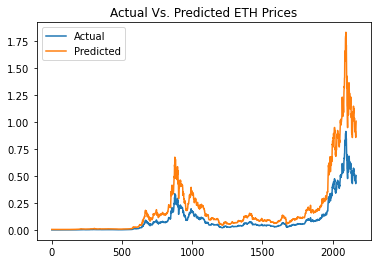

In [41]:
eth_eval.plot(title="Actual Vs. Predicted ETH Prices")